In [1]:
# Imports
import json
import os

from pprint import pprint

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

In [2]:
# !pip install pandas

## CityFlow

In [3]:
from pytsc.backends.cityflow import CITYFLOW_MODULES

## Inputs

In [4]:
SCENARIO = "hangzhou_4_4"

## Functions

In [5]:
def get_trip_gen_stats(flow_file_path):

    with open(flow_file_path, "r") as flow_file:
        flow_data = json.load(flow_file)

    road_counts = {}
    start_times = []
    road_start_times = {}
    route_lengths = {}
    for vehicle in flow_data:
        start_road = vehicle["route"][0]
        start_time = vehicle["startTime"]
        road_counts[start_road] = road_counts.get(start_road, 0) + 1
        start_times.append(start_time)
        if start_road not in road_start_times:
            road_start_times[start_road] = []
        if start_road not in route_lengths:
            route_lengths[start_road] = []
        road_start_times[start_road].append(start_time)
        route_lengths[start_road].append(len(vehicle["route"]))

    total_time_hours = (max(start_times) - min(start_times)) / 3600
    flow_rates = {
        road: count / total_time_hours for road, count in road_counts.items()
    }

    road_arrival_diff_stats = {}
    for road, times in road_start_times.items():
        diffs = np.diff(sorted(times))
        road_arrival_diff_stats[road] = (np.mean(diffs), np.std(diffs))

    combined_results = {}
    for road in road_counts:
        combined_results[road] = {
            "flow_rate": flow_rates[road],
            "arrival_diff_mean": (
                road_arrival_diff_stats[road][0] if diffs.size > 0 else 0
            ),
            "arrival_diff_std": (
                road_arrival_diff_stats[road][1] if diffs.size > 0 else 0
            ),
            "mean_route_length": np.mean(route_lengths[road]),
            "min_route_length": np.min(route_lengths[road]),
            "max_route_length": np.max(route_lengths[road]),
        }

    keys = ["flow_rate", "arrival_diff_mean", "arrival_diff_std"]
    for road in road_counts:
        for k in keys:
            mean_k = f"mean_{k}"
            if mean_k not in combined_results.keys():
                combined_results[mean_k] = 0
            combined_results[mean_k] += combined_results[road][k] / len(
                road_counts
            )

    pprint(combined_results)

In [6]:
def get_flow_rates(flow_file_path):
    with open(flow_file_path, "r") as flow_file:
        flow_data = json.load(flow_file)
    road_counts = {}
    for vehicle in flow_data:
        route = vehicle["route"]
        for road in route:
            road_counts[road] = road_counts.get(road, 0) + 1
    max_count = max(road_counts.values())
    flow_rates = {
        road: count / max_count for road, count in road_counts.items()
    }
    return flow_rates

In [7]:
def plot_graph_with_flow_rates(flow_rates, figsize=12, edge_width_max=4):
    graph = get_networkx_graph()
    max_flow_rate = max(flow_rates.values())
    min_flow_rate = min(flow_rates.values())
    norm_flow_rates = {road: flow_rate / max_flow_rate for road, flow_rate in flow_rates.items()}
    cmap = plt.cm.RdYlGn
    edge_colors = [cmap(norm_flow_rates[edge[2]["label"]]) for edge in graph.edges(data=True) if edge[2]["label"] in norm_flow_rates]
    edge_widths = [norm_flow_rates[edge[2]["label"]] * edge_width_max for edge in graph.edges(data=True) if edge[2]["label"] in norm_flow_rates]
    node_colors = [graph.nodes[node]["color"] for node in graph.nodes()]
    pos = nx.get_node_attributes(graph, "pos")
    fig, ax = plt.subplots(figsize=(figsize, figsize / 1.5))
    nx.draw(
        graph,
        pos,
        with_labels=False,
        node_color=node_colors,
        edge_color=edge_colors,
        width=edge_widths,
        edge_cmap=cmap,
        ax=ax
    )
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Flow Rate')
    plt.tight_layout()

In [8]:
def get_networkx_graph():
    G = nx.Graph()
    for intersection in parsed_network.intersections:
        G.add_node(
            intersection["id"],
            color="red" if not intersection["virtual"] else "gray",
            pos=(intersection["point"]["x"], intersection["point"]["y"]),
        )
    for road in parsed_network.roads:
        start_intersection = road["startIntersection"]
        end_intersection = road["endIntersection"]
        G.add_edge(start_intersection, end_intersection, label=road["id"])
    return G

## Analysis

In [9]:
config = CITYFLOW_MODULES["config"](SCENARIO)

2024-06-02 20:29:23,484 - INFO - Scenario config file: /Users/rohitbokade/repos/pytsc/pytsc/common/../scenarios/cityflow/hangzhou_4_4/config.yaml
2024-06-02 20:29:23,487 - INFO - Config:
{   'cityflow': {   'delta_time': 5,
                    'episode_limit': 360,
                    'flow_file': 'anon_4_4_hangzhou_real_5816.json',
                    'flow_rate_type': 'constant',
                    'initial_wait_time': 0,
                    'interval': 1.0,
                    'lane_change': False,
                    'plan': [5, 30, 30, 30, 30, 30, 30, 30, 30],
                    'replay_log_file': 'frontend/web/replay_log_file.txt',
                    'rl_traffic_light': True,
                    'roadnet_file': 'roadnet_4_4.json',
                    'roadnet_log_file': 'frontend/web/roadnet_log_file.json',
                    'save_replay': False,
                    'seed': 42,
                    'thread_num': 1,
                    'veh_size_min_gap': 7.5,
                

In [10]:
parsed_network = CITYFLOW_MODULES["network_parser"](config)

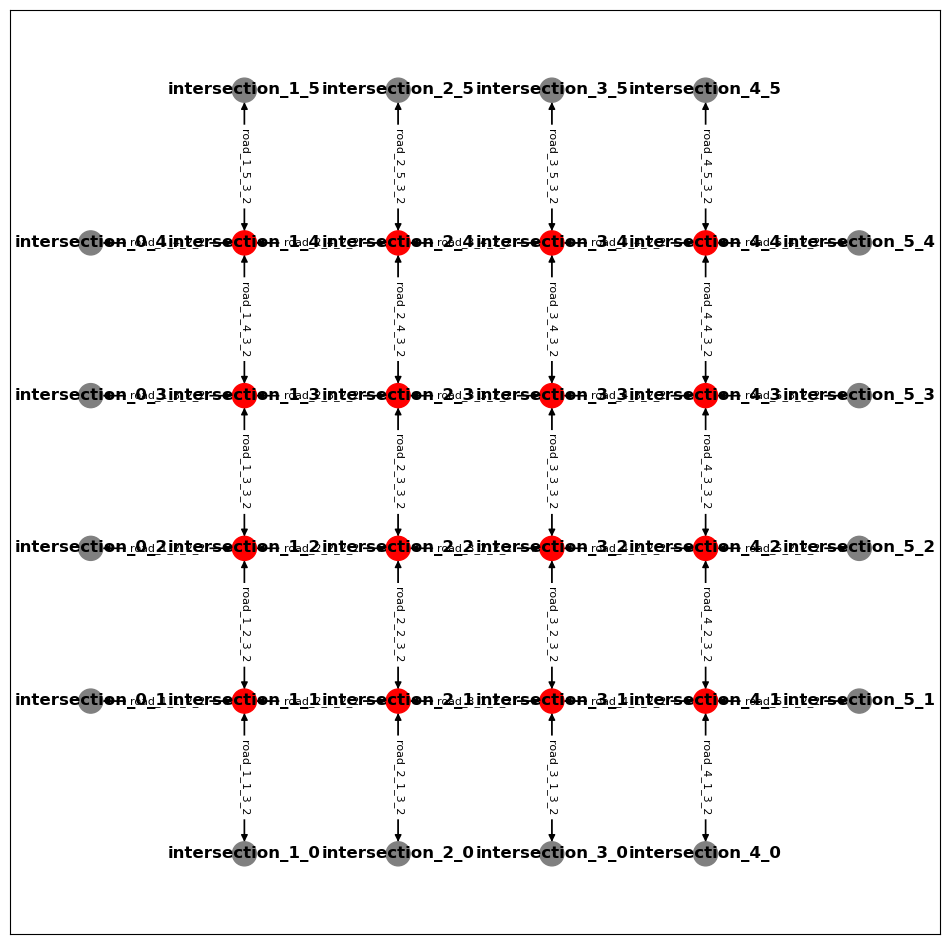

In [11]:
parsed_network.plot_network(figsize=(12, 12))

In [12]:
flow_file_path = os.path.join(config.dir, config.simulator["flow_file"])

In [13]:
get_trip_gen_stats(flow_file_path)

{'mean_arrival_diff_mean': 7.066641000427438,
 'mean_arrival_diff_std': 4.402880795768735,
 'mean_flow_rate': 776.215615448736,
 'road_0_1_0': {'arrival_diff_mean': 5.613104524180967,
                'arrival_diff_std': 4.658719354603379,
                'flow_rate': 642.1783828841345,
                'max_route_length': 15,
                'mean_route_length': 4.1433021806853585,
                'min_route_length': 2},
 'road_0_2_0': {'arrival_diff_mean': 6.998054474708171,
                'arrival_diff_std': 6.857782374376485,
                'flow_rate': 515.1430953042512,
                'max_route_length': 16,
                'mean_route_length': 4.9495145631067965,
                'min_route_length': 3},
 'road_0_4_0': {'arrival_diff_mean': 2.5910727141828653,
                'arrival_diff_std': 2.216784149761743,
                'flow_rate': 1390.3862183939984,
                'max_route_length': 16,
                'mean_route_length': 5.282014388489209,
                'min_ro

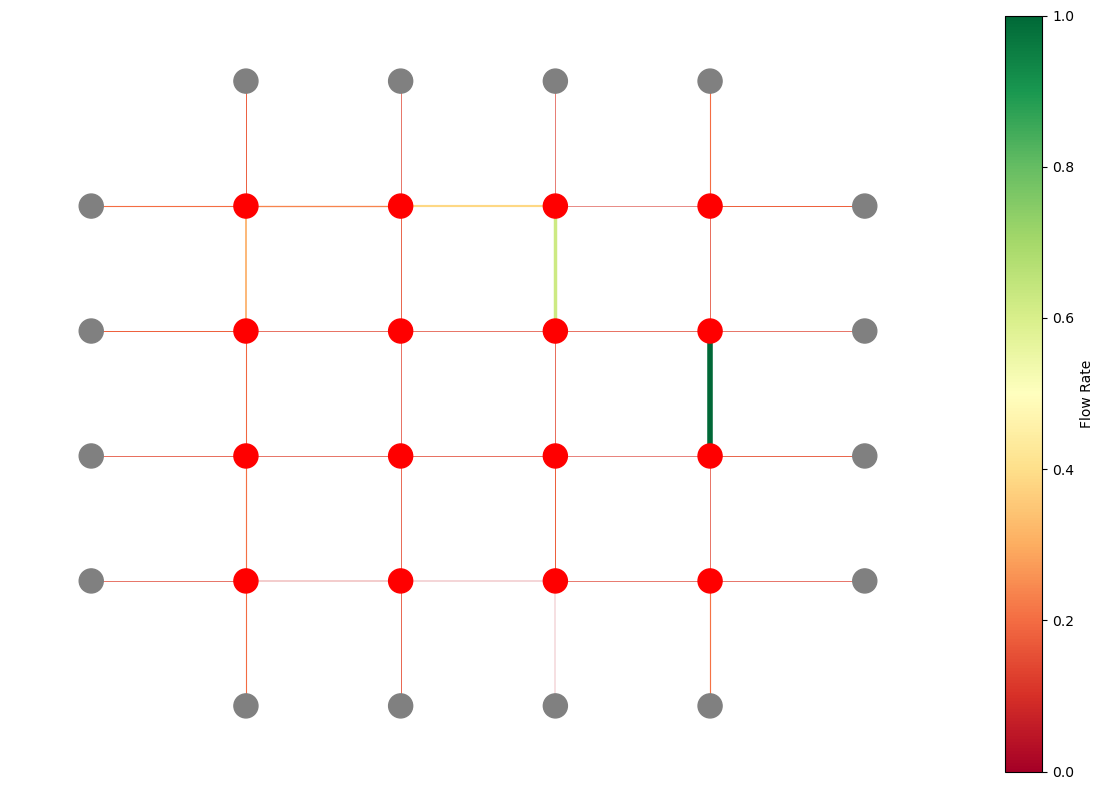

In [14]:
flow_rates = get_flow_rates(flow_file_path)
plot_graph_with_flow_rates(flow_rates)

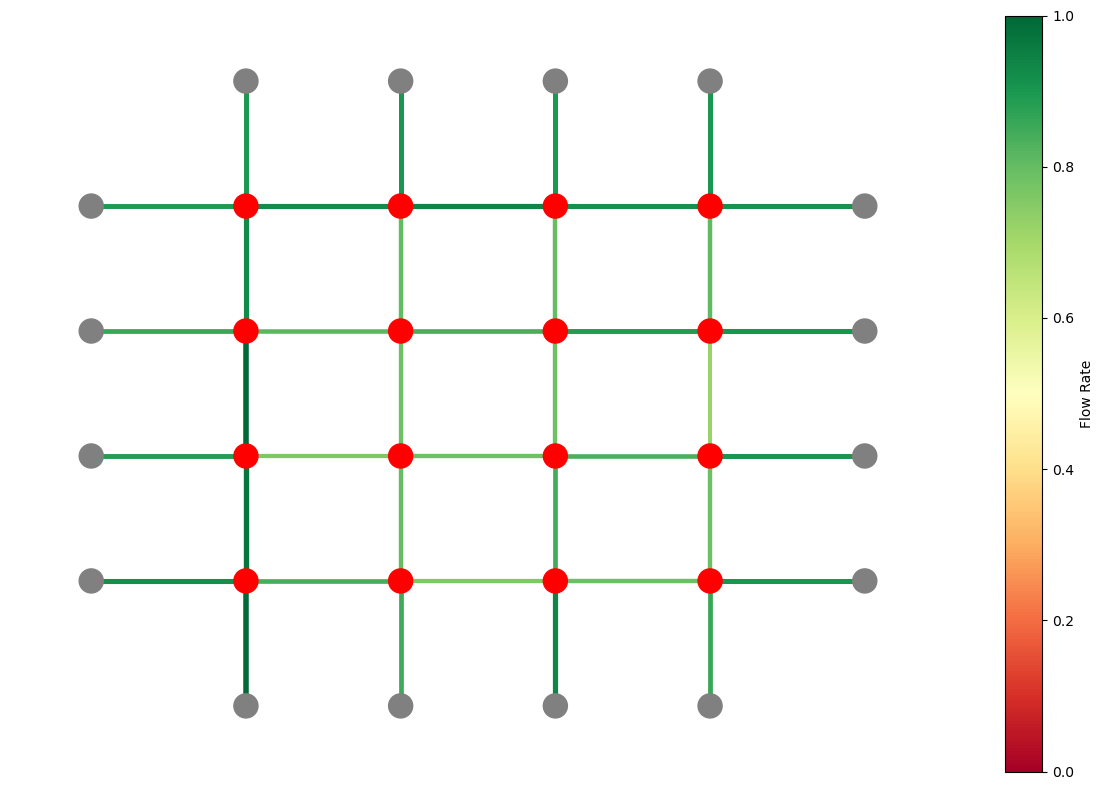

In [15]:
N_REPLICATES = 20
for i in range(1, N_REPLICATES + 1):
    flow_file_path = f'/Users/rohitbokade/repos/pytsc/pytsc/scenarios/cityflow/syn_4x4/{i}__syn_4x4__gaussian_600_flows.json'
    mean_flow_rates = {}
    flow_rates = get_flow_rates(flow_file_path)
    for k, v in flow_rates.items():
        value_update = v / N_REPLICATES
        if k not in mean_flow_rates:
            mean_flow_rates[k] = value_update
        else:
            mean_flow_rates[k] += value_update
plot_graph_with_flow_rates(mean_flow_rates)